# Setup

In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import specific components from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# enhanced stats functions
from scipy import stats

# for ease of data profiling
from pandas_profiling import ProfileReport

In [2]:
# print environment setup details
print(f"pandas version  : {pd.__version__}")  # 1.4.3
print(f"numpy version   : {np.__version__}")  # 1.23.1
print(f"seaborn version : {sns.__version__}") # 0.11.2

pandas version  : 1.4.3
numpy version   : 1.23.1
seaborn version : 0.11.2


Here, we also set the seed for numpy's random number generator such that our results are fully reproducible. This is because the other libraries (e.g. scikit-learn) use this random number generator, so if we set the seed we will always generate the same random numbers in the same sequence.

Thus, whenever we run the notebook from top-to-bottom, we will end up with the *exact* same results! 

In [3]:
SEED = 123
np.random.seed(SEED)

# Data Loading

In [4]:
# read in data
df = pd.read_csv('insurance.csv')
df = df.rename(columns = {"sex":"gender"})

In [5]:
# make sure data was read in properly and matches above table
df.head(2)

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [6]:
df.loc[[650]]

,age,gender,bmi,children,smoker,region,charges
650,49,female,42.68,2,no,southeast,9800.8882


# EDA


**Data dictionary**

| column | data definition | 
| --- | --- | 
| age | age of insured person | 
| gender | sex of insured person, either male or female | 
| bmi | body mass index of insured person |
| children | number of dependents covered by health insurance |
| smoker | does the insured person smoke? |
| region | the insured person's residential area within the US |
| charges | medical costs billed by health insurance; target variable |

For additional information, check the dataset's [information on Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance).

In [7]:
# optional: use pandas-profiling to do quick first pass at EDA
profile = ProfileReport(df, title="Insurance Dataset Profiling Report")
# create html file to view report
profile.to_file("insurance_dataset_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# conduct any other EDA that you need to in order to get a good feel for the data
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Question 1
What is the median age of the individuals in our dataset?

age insurance that divides a population into two numerically equally sized groups.

In [9]:
# calculate median age
df['age'].median()

39.0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Question 2
What is the index of the person who has the highest BMI?

In [11]:
# find index of person with highest BMI
highest = df['bmi'].max()
df.loc[df['bmi'] == highest]

,age,gender,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.4627


## Question 3
Which two independent numeric variables (excluding categorical and dummy variables) are most highly correlated with each other?

charges and age

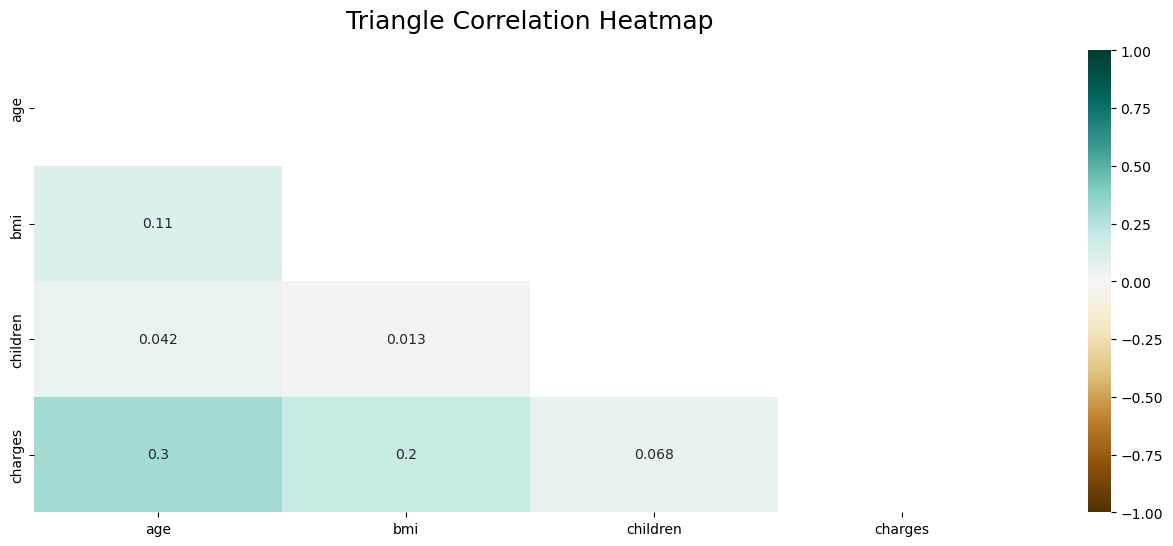

In [12]:
# plot correlation heatmap
plt.figure(figsize=(16,6))
mask=np.triu(np.ones_like(df.corr()))
heatmap = sns.heatmap(df.corr(), mask=mask,vmin=-1,vmax=1, annot =True,cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18},pad=16)
plt.show()

## Question 4
What is the distribution of the `charges` variable in our dataset?

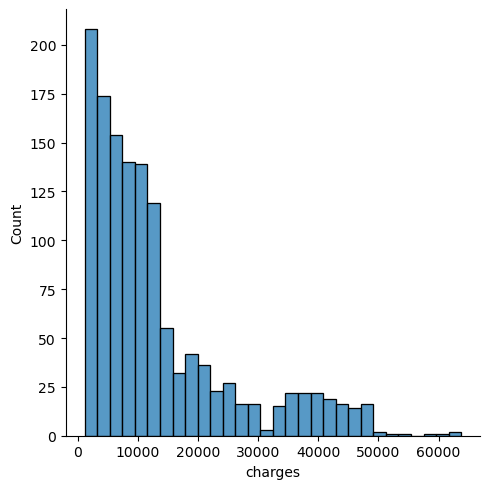

In [13]:
sns.displot(x='charges', data=df)

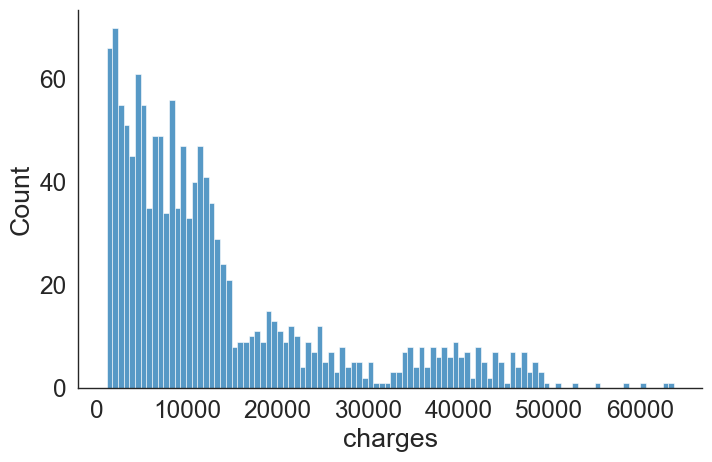

In [14]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df, x="charges", kind="hist", bins = 100, aspect = 1.5)

Looks like we may need to transform our data in some way in order to get it closer to a normal distribution. Create a new column in df, `log_charges`, by taking the log of the existing `charges` column. Then, drop the `charges` column. Your first two rows.

In [15]:
# take log of charges, then drop old column
df["log_charges"] = np.log(df.charges)
df.drop('charges', axis=1, inplace=True)

In [16]:
# check if your table matches the one above
df.head(2)

,age,gender,bmi,children,smoker,region,log_charges
0,19,female,27.90,0,yes,southwest,9.734176
1,18,male,33.77,1,no,southeast,7.453302


now plot the new distribution to see whether it's a normal distribution.

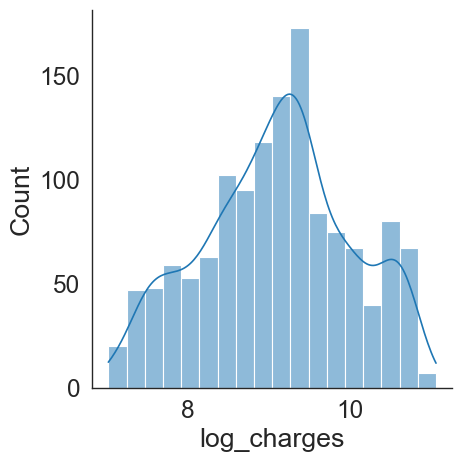

In [17]:
# plot distribution for log_charges
sns.displot(x='log_charges', data=df, kde=True)
plt.show()

Note that even after log transforming our data, it is still not normally distributed. But it is now closer to a normal distribution than the data originally was, so we can continue on with our analysis using this new variable `log_charges` variable as our target variable instead!

## Question 5
There are two rows which are identical to each other; what are their indexes?

In [18]:
# find indexes of duplicated rows
df.loc[df.duplicated(keep=False)]

,age,gender,bmi,children,smoker,region,log_charges
195,19,male,30.59,0,no,northwest,7.402185
581,19,male,30.59,0,no,northwest,7.402185


# Data Wrangling
Now that we have an idea of what our data looks like, we need to start preparing it for modelling.

In this case, we don't have any missing data, so we don't need to do anything about that. We have one duplicated row, but that seems to be legitimate data, so we will keep it in. 

We have 3 categorical variables - gender, smoker, and region. Get dummy variables using pandas, ensuring to use the `drop_first=True` argument to mitigate possible multicollinearity issues. As a result, you should only have one dummy variable for binary values such as `gender` or `smoker`. 

In [19]:
# get dummies for sex, smoker, and region
df = pd.get_dummies(df, columns=['gender','smoker','region'],drop_first=True)
df.head(2)

,age,bmi,children,log_charges,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,9.734176,0,1,0,0,1
1,18,33.77,1,7.453302,1,0,0,1,0


Now verify that we still don't have major multicollinearity issues with a heatmap. What we're looking for is that most of the correlations between independent variables should still be relatively low. There's no single cut-off value (much of this is as much an art as it is a science), but we'll say for our purposes here that we'll consider anything between -0.5 and 0.5 to be low.

Note that if a variable is strongly correlated with our dependent variable `log_charges`, that's okay. If anything, that's probably a good thing!

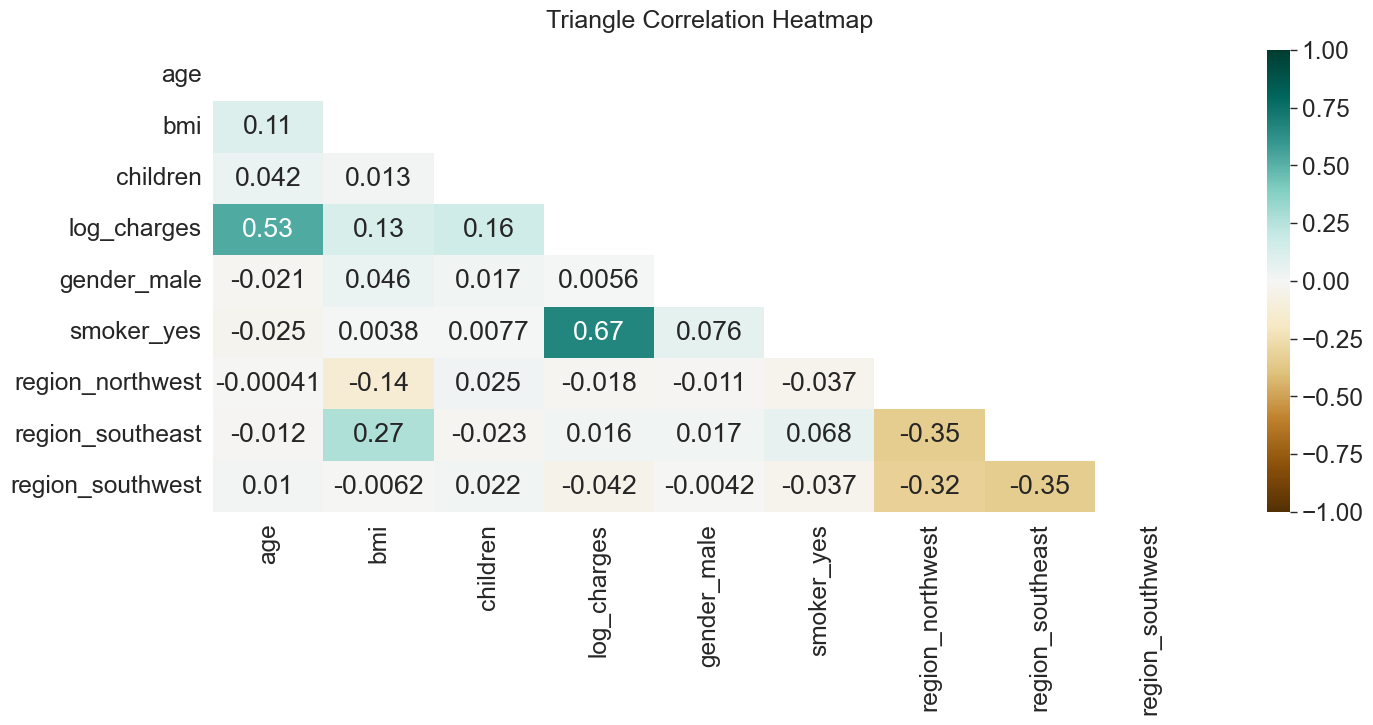

In [20]:
# correlation plot heatmap
plt.figure(figsize=(16,6))
mask=np.triu(np.ones_like(df.corr()))
heatmap = sns.heatmap(df.corr(), mask=mask,vmin=-1,vmax=1, annot =True,cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18},pad=16)
plt.show()

## Question 6
After getting dummy variables from our categorical variables, how many independent variables do we have?

In [21]:
# get number of independent variables
X= df.iloc[:,:-1].values
X.shape[1]

8

Now separate our independent variables into a variable called `X`, and our target variable `log_charges` into a variable called `y`.

In [22]:
# split up our variables
X = df[['age',
 'bmi',
 'children',
 'gender_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest']]
y=df['log_charges']

In [23]:
# the resulting shapes of X and y should be (1338, 8) and (1338,) respectively
print(X.shape)
print(y.shape)

(1338, 8)
(1338,)


Now we need to split up our data into training and test data. Using scikit-learn's `train_test_split` function, using a `test_size` of 0.3 (i.e. 30% of data in test set), and **ensure that the random state is set to our seed from above**.

Documentation for `train_test_split()` can be found here: https://scikit-learn.org/1.1/modules/generated/sklearn.model_selection.train_test_split.html

In [24]:
# do the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

### Question 7
What are the indexes for the first five data points in the training dataset after train_test_split?

In [25]:
y_train.head(5)

300     8.816815
904     9.444985
670     8.484170
617    10.056490
373    10.493639
Name: log_charges, dtype: float64

In [26]:
X_test[:5]

,age,bmi,children,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
650,49,42.680,2,0,0,0,1,0
319,32,37.335,1,1,0,0,0,0
314,27,31.400,0,0,1,0,0,1
150,35,24.130,1,1,0,1,0,0
336,60,25.740,0,1,0,0,1,0


# Modelling and Evaluation
Now we can make our model! Instantiate a LinearRegression model in scikit-learn, then fit the training data on it.

Documentation for `LinearRegression()` can be found here: https://scikit-learn.org/1.1/modules/generated/sklearn.linear_model.LinearRegression.html

In [27]:
# instantiate linear regression model and fit the training data to it
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [28]:
lr.score(X_test,y_test)

0.7841289883812208

In [29]:
lr.intercept_

6.987675223271668

In [30]:
# describe model
print(f"intercept: {lr.intercept_:.4f}")
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}: {lr.coef_[i]:.4f}")

intercept: 6.9877
age: 0.0347
bmi: 0.0151
children: 0.1070
gender_male: -0.0837
smoker_yes: 1.5320
region_northwest: -0.0879
region_southeast: -0.1546
region_southwest: -0.1433


Now we need to evaluate how our model did. Let's start by gathering some basic metrics on the training data (e.g. MAE, RMSE, R^2), then do the same on the test set.

In [31]:
# predict training set values
predictions_train = lr.predict(X_train)

In [32]:
# evaluate model R^2 (score)
r2_train = r2_score(y_train,predictions_train)

In [33]:
# evaluate model MAE
mae_train = mean_absolute_error(y_train,predictions_train)

In [34]:
# evaluate model RMSE
rmse_train = np.sqrt(mean_squared_error(y_train,predictions_train))

In [35]:
# print metrics
print("metrics for training data")
print(f"R^2 score : {r2_train:.4f}")
print(f"mae       : {mae_train:.4f}")
print(f"rmse      : {rmse_train:.4f}")

metrics for training data
R^2 score : 0.7608
mae       : 0.2880
rmse      : 0.4557


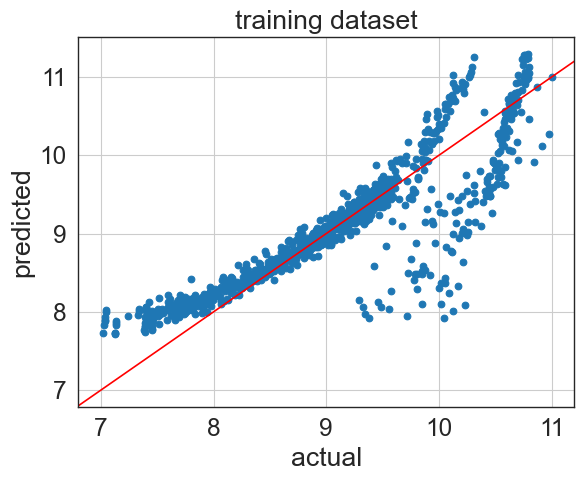

In [36]:
# plot predictions against actual values
plt.scatter(y_train, predictions_train)
plt.title("training dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()
plt.show()

Clearly, while our model has clearly learned something about the data, there is still room for improvement.

Now we're going to evaluate our model's performance on the test set. First, we need to make our model predict the values for the test set.

In [37]:
# make predictions on test set
predictions_test = lr.predict(X_test)

In [38]:
# get same metrics as before - R^2, MAE, RMSE
r2_test = r2_score(y_test,predictions_test)
mae_test = mean_absolute_error(y_test,predictions_test)
rmse_test = np.sqrt(mean_squared_error(y_test,predictions_test))

In [39]:
# print metrics
print("metrics for test data")
print(f"R^2 score : {r2_test:.4f}")
print(f"mae       : {mae_test:.4f}")
print(f"rmse      : {rmse_test:.4f}")

metrics for test data
R^2 score : 0.7841
mae       : 0.2697
rmse      : 0.4129


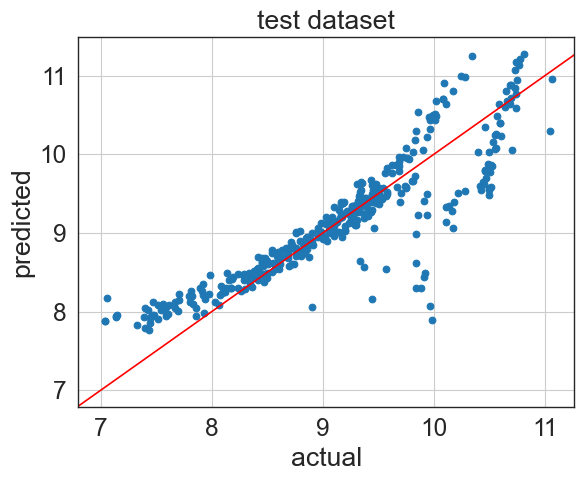

In [40]:
# plot predictions against actual values
plt.scatter(y_test, predictions_test)
plt.title("test dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()
plt.show()

## Question 8
Are the residuals normally distributed?

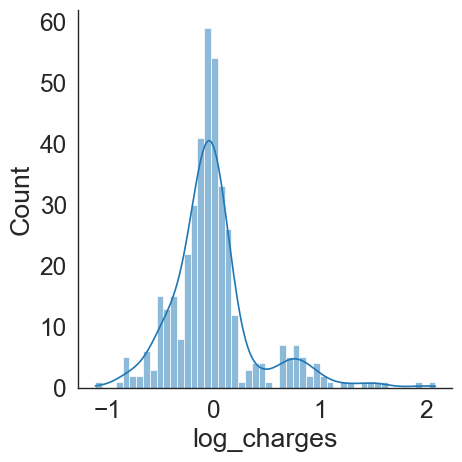

In [41]:
# plot residuals to determine if they are normally distributed
sns.displot((y_test-predictions_test),bins=50, kde=True);

Now, let's take a step back. We know that we took the log of `charges` in order to make it closer to a normal distribution. While this is helpful for our modelling, at the end of the day we want to predict the actual insurance charges, not the log of them.

## Question 9
What are the predicted insurance charges for index 650 (the first row in the test dataset), rounded to 2 decimal places (i.e. nearest cent)?

In [42]:
df.loc[[650]]

,age,bmi,children,log_charges,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
650,49,42.68,2,9.190228,0,0,0,1,0


In [49]:
import math
actual = df.loc[650, 'log_charges']
actual = round(math.exp(actual),2)
actual

9800.89

In [50]:
X_t = X_test.loc[[650]]
X_t

,age,bmi,children,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
650,49,42.68,2,0,0,0,1,0


In [51]:
# get predicted insurance charge for index 650
charge = lr.predict(X_t)
charge = math.exp(charge)
charge = (round((charge),2)) 
charge

11995.36

In [57]:
rmse = charge - actual
rmse = round(rmse)
rmse = (rmse)**2
rmse = np.sqrt(rmse)
rmse

2194.0

In [47]:
mae = abs(charge -actual)

intercept           : 6.9877
age                 : 0.0347
bmi                 : 0.0151
children            : 0.1070
gender_male         : -0.0837
smoker_yes          : 1.5320
region_northwest    : -0.0879
region_southeast    : -0.1546
region_southwest    : -0.1433
---------------------------------------
Predicted insurance charges: 11995.36
Actual insurance charges: 9800.89
rmse:46.82
rmse:2194.47
---------------------------------------


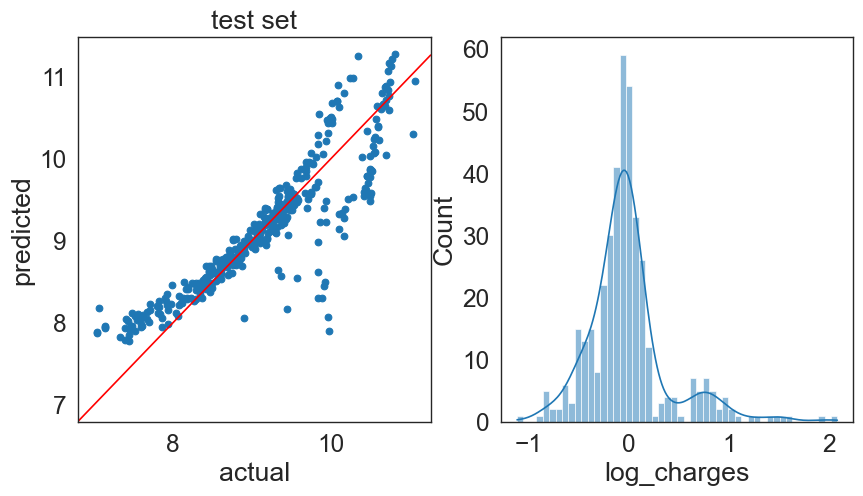

In [48]:
print(f"{'intercept':<20}: {lr.intercept_:.4f}")
for i in range(len(X_t.columns)):
    print(f"{X_t.columns[i]:<20}: {lr.coef_[i]:.4f}")
print("---"*13)
# get predicted insurance charge for index 650
print(f"Predicted insurance charges: {charge:.2f}")
print(f"Actual insurance charges: {actual:.2f}")
#print(f"rmse:{r2:.2f}")
print(f"rmse:{rmse:.2f}")
print(f"rmse:{mae:.2f}")
print("---"*13)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,5)

# draw plots for test set
# ax1 - scatter plot of predictions vs actual
ax1.scatter(y_test, predictions_test)
ax1.axline([7, 7], [11, 11], color="red")
ax1.set_title("test set")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")

# ax2 - residuals plot
sns.histplot((y_test-predictions_test), bins=50, kde=True, ax=ax2)

plt.show()